# Analyzing Cultural Diversity through Census Data of Language Spoken at Home

By Jordan Crawford-O'Banner and Alli Busa

In the news, we've heard that diversity has increased in the United States. While the Census has praised the U.S. for becoming overall more racial and ethnically diverse, FOX newscaster Tucker Carlson has claimed that the rise of immigrants in the U.S. is not happening in "politicians' neighborhoods". (See Project Proposal)

We wanted to take these two clashing statements and put them both to the test. Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? Are regions with high ratios of non-English speakers actually linguistically diverse or homogenuously consisting of a non-English speaking community? 

## Importing Necessary Packages and Setting Up Data Imports

Importing necessary packages.

In [1]:
%matplotlib inline

#Packages for Calculating
import pandas as pd
import numpy as np
from thinkstats2 import Pmf, Cdf
import thinkstats2

#Packages for Plotting
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white')
import thinkplot
from IPython.display import display_html, HTML

The data that we will be analyzing for this project is the Census' datasets on language in the U.S., which is available to everyone for noncommercial use. Specifically, the data is the Census' processed responses to the questions,"Does this person speak a language other than English at home?" and "What is this language?". The Census is filled out by one family member for the whole household and the questions posed to the Census respondents are the questions in quotations above for the whole duration of our dataset. (see https://www.census.gov/topics/population/language-use/about/historical.html). Ideally, every household with a U.S. citizen should respond to the Census, because it is federal law to fill it out. We acknowledge however, that undocumented citizens, whose majority probably would inform our language data, do not fill out the survey. Nonetheless, we trust the Census data to be valid, because it is federally governed. </p>
We have three data sets from the Census. They contain a list of over 380 languages that Americans speak at home and the corresponding number of Americans who speak each language for 2000, the 2006 to 2008 period and the 2009 to 2013 period. 
In each of these periods, the way that the data was has been processed into excel documents has changed. For example, in the year 2000 data, the excel spreadsheets are states and contain data on the state as a whole and its counties. These two different variables are given in the same column. On the other hand, in the 2009-2013 data, the counties data and states data are given in two separate excel files altogether. In the 2006-2008 data, there is no data set by counties. </br>
There were some responses to lesser known languages that were omitted due to a very few number of respondents. We account for this issue while organizing our data set below. 



##### Creating Functions and Lists Used for Parsing

In order to collect data from multiple Excel sheets more efficiently, we will create a list of state abbreviations and state names. This is important because the data that has been provided to us for 2006 and 2009 has separated the data for each state onto a different sheet within the excel file. We are creating two lists because some of our data's sheet names are state abbreviations and some are counties. 

In [2]:
#State abbreviations
#Taken from https://gist.github.com/JeffPaine/3083347
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
"SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

#State names
#Taken from https://gist.github.com/tleen/6299431
statesfull=['Alabama','Alaska','Arizona','Arkansas','California','Colorado','Connecticut',
           'Delaware','Florida','Georgia',
            'Hawaii','Idaho','Illinois','Indiana','Iowa','Kansas','Kentucky','Louisiana','Maine',
            'Maryland','Massachusetts','Michigan','Minnesota','Mississippi','Missouri','Montana','Nebraska',
            'Nevada','New Hampshire','New Jersey','New Mexico','New York','North Carolina','North Dakota',
            'Ohio','Oklahoma','Oregon','Pennsylvania',
            'Rhode Island','South Carolina','South Dakota','Tennessee','Texas','Utah','Vermont',
            'Virginia','Washington','West Virginia','Wisconsin','Wyoming']

We will create a function called createSeries, which will allow us to create a Pandas Series from multiple sheets within an Excel file. 

In [3]:
def createSeries(arrayNames, textfileName, index, Column, skiprows=[0,1,2]):
    """
    Makes a Series with specific language information from excel file. 
    It is used for organizing data on total English speakers and total non-English speakers.


    arrayNames - this will be either states or statesfull, depending on how Excel sheets are organized
    textfileName - the datafile
    index - either 0 for total English speakers or 1 for total non-English speakers
    Column - depending on the year, the column which contains the number of speakers is either given as "Number of speakers" or "Number of speakers1"
    skiprows - the number of rows before the data begins changes based on Excel file. For the 2006-2008 data, it is [0,1,2], for the 2009-2013 data, it is [0,1,2,3]

    """
    emptySeries = pd.Series()
    i=0
    for area in arrayNames:

        df = pd.read_excel(textfileName, area, skiprows=skiprows).dropna()

        #dictionary[area] = df.loc[dictionaryindex1:dictionaryindex1,Column]
        emptySeries.set_value(i,df.loc[index, Column])
        
        i+=1
    
    #Clean Data
    emptySeries.replace(['(X)', '--'], np.nan, inplace=True)
    emptySeries.replace(['(B)'],0, inplace=True)
    
    return emptySeries
    

Note that this function also cleans the data. 
There are some entries which do not have numerical entries due to sampling error. For example, 'X' indicates that the question does not apply. 
We changed 'B' to 0, because those entries indicate that there were too few sample observations to compute an estimate, and we decided that 0 is more representative of that sampling error.

### Importing and Organizing Data

We have decided to start by creating Series and Dataframes of Americans who speak English at home and Americans who speak another language at home. We will refer to former group of people as EOS, 'English Only Speakers', and to the latter group of people as SONELAHs, which stands for 'Speakers of non-English languages at Home'.

First, we will create a Series of English Speakers at home and SONELAHs as well as a Dataframe for the Census data from 2000. The Census data was formatted differently, so took a different approach to processing this data. We created functions which would parse the 2000 Census data and then create CSV files from it. These functions can be found in the Parse2000 Notebook in this repository.

In [4]:
def createStateDF2000(sheet,area):
    """
    Takes in two empty series and a state.
    countyList - a list which will be populated with names of counties in state
    countyNumbers - a list containing total speakers of other languages per county
    state - state you wish to look at, given as ex: ["AZ"]
    index - the row number in which t
    """
    dataframe=pd.DataFrame()
    for i in range(0,51):
        parsetest =  pd.read_excel("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_2000.xlsx", sheet[i], skiprows=[0,1,2,3]).dropna()
        eng=parsetest[(parsetest["Area Name (State or County)"]==area[i])& (parsetest["Language Code"]==0)]
        sonnie=parsetest[(parsetest["Area Name (State or County)"]==area[i])& (parsetest["Language Code"]!=0)]
        langArray=[sum(eng["Number of speakers"]),sum(sonnie["Number of speakers"])]
        dataframe[area[i]]=langArray
    dataframe=dataframe.T
    dataframe=dataframe.set_index(pd.Index(range(0,51)))
    dataframe=dataframe.rename(columns={0:"English Speakers",1:"SONELAHs"})
    dataframe["States"]= states
    return dataframe

In [5]:
#Creating Series
eos2000 = pd.read_csv("/home/alli/The-Mother-Tongue-of-US-Communities/eng2000state.csv").iloc[0]
sonelah2000 = pd.read_csv("/home/alli/The-Mother-Tongue-of-US-Communities/other2000state.csv").iloc[0]

#Cleaning Dataset
eos2000["DC"]=  np.nan
sonelah2000["DC"]= np.nan

#Creating Dataframe
df2000=pd.DataFrame({"States": states,"EOS":eos2000[:50],"SONELAHs":sonelah2000[:50]})


Notice that we set the DC values to nan. We did this because the DC data for this file has language multiple times with no distinction, making it hard to parse. We suppose that this is because DC is separated into counties, but those counties weren't listed. In order to acommodate for this, we took DC data out of all the datasets by not including it states list.

Next, we will create the same Series and Dataframe for the 2006 data. The 2006 data is organized in multiple sheets, which are given by the state abbreviation.

In [6]:
#Referencing Textfile
txtfile2006 = "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/DetailedLanguageSpoken_State_20062008.xls"

#Creating Series
eos2006 = createSeries(states, txtfile2006, 1,"Number of speakers", skiprows=[0,1,2])
sonelah2006 = createSeries(states, txtfile2006, 2,"Number of speakers", skiprows=[0,1,2])

#Creating Dataframe
df2006=pd.DataFrame({"States": states,"EOS":eos2006,"SONELAHs":sonelah2006})

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


Lastly, we will create the same Series and Dataframe for the 2009 data. The 2009 data is organized in multiple sheets, which are given by the full state names. This data is also parsed differently, because the column name which belongs to the column that provides number of speakers is given as "Number of speakers1" instead of "Number of speakers". Also, in this Excel file, the parser needs to skip the first four rows, instead of the first three (initialized at 0).

In [7]:
#Referencing Textfile
txtfile2009 =  "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_State_2009-2013.xls"

#Creating Series
eos2009 = createSeries(statesfull, txtfile2009, 1,"Number of speakers1", skiprows=[0,1,2,3])
sonelah2009 = createSeries(statesfull, txtfile2009, 2,"Number of speakers1", skiprows=[0,1,2,3])

#Creating Dataframe
df2009=pd.DataFrame({"States": states,"EOS":eos2009,"SONELAHs":sonelah2009})

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


## State-Wide Analysis

We will begin by plotting PMFs and creating tables to try to answer "Has cultural diversity, measured through linguistic diversity, increased significantly in the past few years? How is cultural diversity, through linguistic diversity, spread out throughout the U.S.? " on a statewide level.

##### Functions
First, we will create functions which will help us analyze and graph the data. 

In [8]:
def createPMFs(df):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns the same Dataframe with a column of PMFs of SONELAHs by state, sorted from 
    least to greatest.
    
    df - dataframe which contains the sorted number of EOS and SONELAHs per census file. ie: df2009
    """
    sonelah=df["SONELAHs"]
    eos=df["EOS"]
    df["PMF"] = sonelah/(sonelah+eos)
    df=df.sort_values(by="PMF") #sorts from least to greatest
    
    return df

In [9]:
def plotPMFs(df, ax=None):
    """
    Takes the dataframe which contains the number of EOS and SONELAHs per census file. 
    Returns two graphs with PMF of only English speakers and PMF of speakers of 
    other languages as normalized percentages of total population of those states. 
    
    df - dataframe which contains the number of EOS and SONELAHs per census file. ie: df2009
    """
    dfwithPMF = createPMFs(df) #Adding a PMF column
    i =0 #begining a counter to help plot SONELAHs
    if ax is None:
        plt.figure(figsize=(20, 3)) 
    for state in dfwithPMF["PMF"]:
        ax.bar(i, state,  color='#B6D7A8')
        plt.autoscale(enable=True)
        plt.ylim([0.0,1.0])
        plt.setp(ax, xticks=range(0,51), xticklabels=dfwithPMF["States"])
        plt.setp(ax.get_xticklabels(), rotation=45)
        plt.tick_params(axis='both', which='major', labelsize=20)
        #ax.set_xlabel("State")
        #ax.set_ylabel("Percentage of SONELAHs")
        i+=1
    return ax

In [10]:
def createTemporalTable(df2000, df2006, df2009):
    """
    Takes in the dataframes which contain the number of EOS and SONELAHs per census period.
    Returns a table that shows the top ten states with the highest percentage of SONELAHs.
    """
    
    df2000 = createPMFs(df2000) #Creates PMFs for each dataset and appends
    df2000['Percentage'] = df2000['PMF'].multiply(100.*np.ones(len(df2000['PMF']))) #Turns the PMF into a percentage
    sorteddf2000 = df2000.sort_values(by='Percentage',ascending=False) #Sorts data in order of greatest to least percentage
    sorteddf2000.index = list(range(1,len(sorteddf2000.index)+1)) #creating index for rank
    
    df2006 = createPMFs(df2006) 
    df2006['Percentage'] = df2006['PMF'].multiply(100.*np.ones(len(df2006['PMF']))) 
    sorteddf2006 = df2006.sort_values(by='Percentage',ascending=False) 
    
    df2009 = createPMFs(df2009) 
    df2009['Percentage'] = df2009['PMF'].multiply(100.*np.ones(len(df2009['PMF']))) 
    sorteddf2009 = df2009.sort_values(by='Percentage',ascending=False) 
    
    df2000_styler = sorteddf2000.iloc[0:10,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2000')
    df2006_styler = sorteddf2006.iloc[0:10,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2006').hide_index()
    df2009_styler = sorteddf2009.iloc[0:10,[2,4]].style.set_table_attributes("style='display:inline'").set_caption('2009').hide_index()
    chart = HTML('<h1>Rank of SONELAHs by State</h1>')
    display(chart)

    display_html(df2000_styler._repr_html_()+df2006_styler._repr_html_()+df2009_styler._repr_html_(), raw=True)
    

In [11]:
def returnStatesfromRatio(df, percent, sign):
    """
    Takes in a pair of total EOS and SONELAHs, as well as desired ratio and comparison
    Returns a table with the number of states which have a percentage of SONELAHs
    which is less than or more than the percentage specified. 

    Percent - Give percent in range (0:1)
    Sign - "Less" or "More"
    """
    dfwithPMF = createPMFs(df) #Adding a PMF column

    if sign == "Less":
        result = dfwithPMF[dfwithPMF["PMF"]  < percent]
    if sign == "More":
        result = dfwithPMF[dfwithPMF["PMF"]  > percent]
        
    print(result[["States", "PMF"]])


##### Plotting and Creating Tables

The first visualization that we are making is a table that shows the top ten states with the highest percentage of SONELAHs in the U.S., in the three time periods for which we have the data. We are creating this to show where the highest linguistic might be, and how that is changing over time.

In [12]:

createTemporalTable(df2000, df2006, df2009)

,States,Percentage
1,DE,59.6038
2,CA,39.4735
3,NY,36.4809
4,UT,31.235
5,NC,27.9591
6,ID,26.6028
7,AZ,25.8515
8,NM,25.4727
9,GA,23.088
10,NH,23.0585


We see that California always has the number of SONELAHs. We infer that this is because California is state that belonged to Mexico, is a coastal state and contains many large cities. California belonging to Mexico means that there possibly is a higher percentage of Spanish speakers. California being a coastal state that contains many large cities means that it has a lot of places that are practically for an immigrant to come to when immigrating. <br>
We also see that a lot of states on this list fluctuate in their rank. For example, New Mexico is 9th in 2000, but 2nd in the 2006-2008 period and the 2009-20013 period.

In order to see the fluctations in rank of some of the states on our top ten chart, we will plot the PMFs of SONELAHs by state per year. 

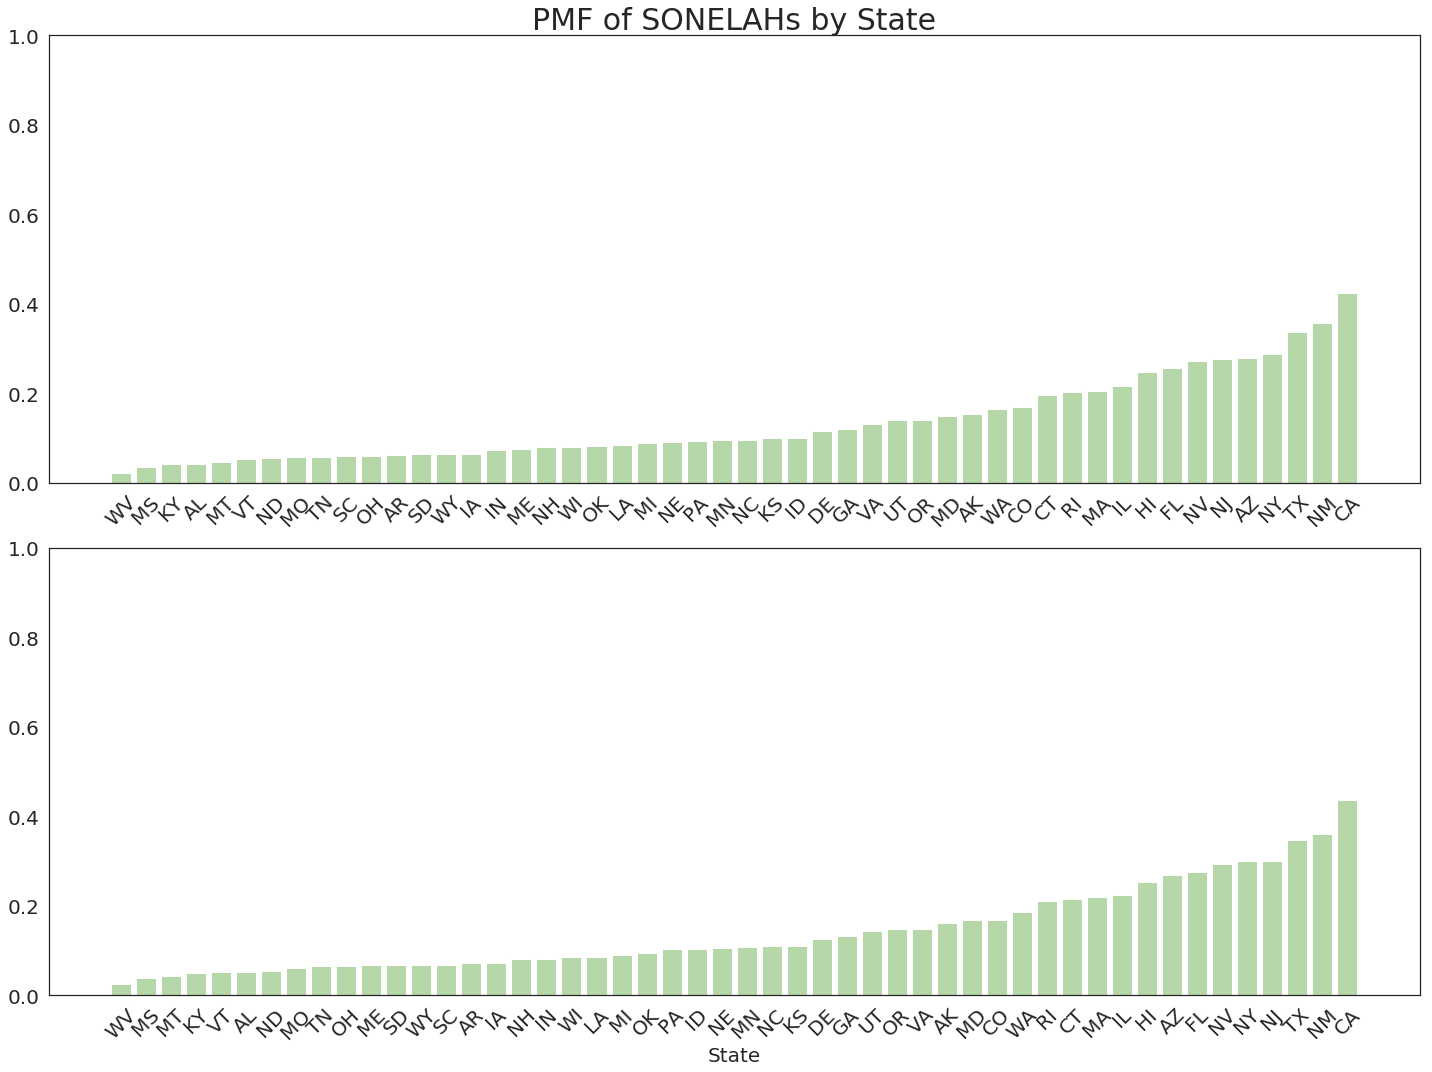

In [13]:

fig, (ax1,ax2) = plt.subplots(2,1, figsize=(20,15), sharey=True)  # 1 row, 2 columns
plotPMFs(df2006, ax=ax1)
plotPMFs(df2009, ax=ax2)
ax1.set_title('PMF of SONELAHs by State', fontsize=30)
ax2.set_xlabel('State', fontsize=20)
plt.setp(ax1.get_xticklabels(), rotation=45)
ax1.tick_params(axis='both', which='major', labelsize=20)
plt.tight_layout() 

** Resolve DC
We see that throughout these three time periods, the shape of distribution and the magnitude of the percentages are relatively the same. We do see that the order of the distribution changes, however. California is first all years, but the other states shift position. New Jersey, for example, has a lower percentage of SONELAHs in the first time period, which increases in the second time period. In the last time period, New Jersey has the fourth highest percentage of SONELAHs.

</p>
States with large cities, coastal states and Southwestern states have more SONELAHs. This makes sense because Southwestern states were part of a region of Mexico, and have Latin heritage. Also, coastal states and states with large cities are attractive places for immigrants to live, because of the 
From these graphs, we also see the distribution at the lower end of the spectrum.

## County-Wide Analysis

From analyzing linguistic diversity at the state level, we wanted to explore states with very high and very low percentages of SONELAHs more closely. We did this to test whether states which have high percentages of SONELAHs have spread out or concentrated linguistic diversity. We also wanted to see if this same fluctation over time we saw in the state level applied to the county level. 

##### Functions
First, we will create functions which will help us analyze and graph the data.

In [14]:
def createCountyNames(state):
    """
    Takes in a state. Returns a list of 
    counties in that state in the 2009-2013 period without the state abbreviation attached to it    
    
    state - state given ["stateabbreviation"], ie "CA"
    """
    countyNames = pd.Series()
    i=0
    x1 = pd.ExcelFile("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls")
    sheetnames = x1.sheet_names
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            df = pd.read_excel("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls",sheet, skiprows=[0,1,2,3]).dropna()
            countyNames.set_value(i, sheet[:len(sheet)-4])
            i+=1
    return countyNames

In [15]:
def createStateDataFrame2000(state):
    """
    Takes in a state and returns a dataframe containing the counties and the 
    number of SONELAHs and EOS per county from 2000
    
    state - state given "stateabbreviation", ie "CA"
    """
    counties = createCountyNames([state])#list of counties
    lang=["English Only","SONELAHs","SPANISH AND SPANISH CREOLE",'German, Scandinavian, Italian',"ASIAN AND PACIFIC ISLAND LANGUAGES",'Native North American']
    df=pd.DataFrame(index=lang,columns=counties)
    parsetest =  pd.read_excel("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_2000.xlsx", state, skiprows=[0,1,2,3]).dropna()
    for county in counties: 
        eng=parsetest[(parsetest["Area Name (State or County)"]==county)& (parsetest["Census Tract Code"]==0) & (parsetest["Language Code"]==0)]
        sonnie=parsetest[(parsetest["Area Name (State or County)"]==county)& (parsetest["Census Tract Code"]==0) &(parsetest["Language Code"]!=0)]
        esp=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]==627) | (parsetest["Language Code"]==625) | (parsetest["Language Code"]==628))]
        europe=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]==607) | (parsetest["Language Code"]>=614) & (parsetest["Language Code"]<=619))]
        asian=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]<=695) & (parsetest["Language Code"]>=684) | (parsetest["Language Code"]<=771) & (parsetest["Language Code"]>=698))]
        native=parsetest[(parsetest["Area Name (State or County)"]==county) & (parsetest["Census Tract Code"]==0) &((parsetest["Language Code"]<=955) & (parsetest["Language Code"]>=800) | (parsetest["Language Code"]<=966) & (parsetest["Language Code"]>=959)| (parsetest["Language Code"]<=982) & (parsetest["Language Code"]>=977))]
        langArray=[sum(eng["Number of speakers"]),sum(sonnie["Number of speakers"]),sum(esp["Number of speakers"]),sum(europe["Number of speakers"]),sum(asian["Number of speakers"]),sum(native["Number of speakers"])]
        df[county]=langArray
    df=df.T
    df=df.set_index(pd.Index(range(0,len(counties))))
    df=df.rename(columns={0:"English Speakers",1:"SONELAHs"})
    df["County"]= counties
    return df

This function takes in a given state, an empty list for counties and an empty list for SONELAHs per county. It returns the information about the desired state's counties and SONELAHs in them into the empty lists.

In [16]:
def createStateDataFrame2009(state):
    """
    Takes a state and returns the counties and the number of SONELAHS per county in the 2009-2013 period. 
    
    Takes:
    state - state you wish to look at, given as ex: ["AZ"]
    
    Returns:
    df - contains counties, number of EOS per county and number of SONELAHs per county

    """
    countyList = pd.Series()
    SONELAHNumbers = pd.Series()
    EOSNumbers = pd.Series()
    i=0
    x1 = pd.ExcelFile("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls")
    sheetnames = x1.sheet_names #Extract the County Names from the Excel Sheet Names
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            df = pd.read_excel("/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls",sheet, skiprows=[0,1,2,3]).dropna()
            SONELAHNumbers.set_value(i,df["Number of speakers1"][2]) #Append to list of SONELAHS per county from the desired state
            countyList.set_value(i, sheet) #Append to list of counties from the desired state
            EOSNumbers.set_value(i,df["Number of speakers1"][1]) #Append to list of EOS per county from the desired state
            i+=1
    df = pd.DataFrame({"County":countyList, "SONELAHs":SONELAHNumbers, "EOS": EOSNumbers})
    return df

In [17]:
def plotCounty(state):
    """
    Takes in the name of a state. The function will find the value of
    SONELAHS for the state in the 2000's and and the two Dataframes  
    which createCountySeries filled
    Plots the number of of SONELAHs by county
    
    state - the state you wish to look at, given as ex: "AZ"
    """
    dft1= createStateDataFrame2000(state)
    dft1=dft1.sort_values(by="SONELAHs")

    dft2=createStateDataFrame2009([state])
    dft2=dft2.sort_values(by="SONELAHs")

    ax=plt.subplot(111)
    i=0
    for SONELAH1,SONELAH2 in zip(dft1["SONELAHs"],dft2["SONELAHs"]): 
        ax.bar(i-0.2,SONELAH1,width=0.4,color='b',align='center')
        ax.bar(i+0.2,SONELAH2,width=0.4,color='g',align='center')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(dft1)), dft1["County"],  rotation=90)
        plt.title("SONELAHs in "+str(state)+" by County")
        plt.xlabel("County")
        plt.ylabel("Number of SONELAHs")
        i+=1
        ax.legend(["2000","2009-2013"])

In [18]:
def plotCountyPMF(statename):
    """
    Takes in the name of a state
    Plots the PMF of SONELAHs of certain language groups by county for 2000 and 2009-2013.
    
    state - given as ie "AK"
    """
    dft1=createStateDataFrame2000(statename)
    dft1["norm"] = dft1["SONELAHs"]/(dft1["English Only"] + dft1["SONELAHs"])
    dft2=createStateDataFrame2009([statename])
    dft2["norm"] = dft2["SONELAHs"]/(dft2["EOS"] + dft2["SONELAHs"])
    ax=plt.subplot(111)# Determines size of plot
    i=0
    for thing1,thing2 in zip(dft1["norm"],dft2["norm"]): 
        ax.bar(i-0.2,thing1,width=0.4,color='b',align='center')
        ax.bar(i+0.2,thing2,width=0.4,color='g',align='center')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(dft1)), dft1["County"],  rotation=90)
        plt.title("Other Language Speakers in "+str(statename)+" by County")
        plt.xlabel("County")
        plt.ylabel("PMF of Other Language Speakers")
        i+=1
        ax.legend(["2000","2009-2013"])

In [23]:
def createCountiesList(state):
    """
    Creates a list of counties from the 2009-2013 counties list, when you input a state you want to analyze
    
    state - given as ex "CA"
    """
    textfileName =  "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    countyNames = []
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names                        
    for sheet in sheetnames:
        if any(x in sheet for x in state):
            
            countyNames.append(str(sheet))

    return countyNames

In [24]:
def createListofLanguageGroupsCounties(state):
    """
    Takes in state  and returns dataframe which contains language groups and corresponding 
    number of respondents who speak a language in that language group
    
    state - given as "CA"
    """
    #Reading Excel spreadsheet
    textfileName =  "/home/alli/The-Mother-Tongue-of-US-Communities/raw_data/LanguageSpokenatHome_County_2009-2013.xls"
    #Initializing languages which we are looking for
    languagegroupstolookfor = ["SPANISH AND SPANISH CREOLE", ".Italian","..German", ".Scandinavian languages","..Pennsylvania Dutch",
                                 "ASIAN AND PACIFIC ISLAND LANGUAGES",".Navajo", ".Other Native North American languages"]
    #Initializing counties list 
    countyNames = createCountiesList(state)
    #Create emtpy dataframe
    languagesperState = pd.DataFrame(np.nan, index= np.array(countyNames), columns=np.array(languagegroupstolookfor)) #row index will be language and column index will be column index
    #Looping through the sheets and if the language and county are there, add it
    x1 = pd.ExcelFile(textfileName)
    sheetnames = x1.sheet_names
    for sheet in sheetnames:

        if sheet in countyNames:

            df = pd.read_excel(textfileName, sheet, skiprows=[0,1,2,3]).dropna()
            
            for language in languagegroupstolookfor:
                try:
                    num = df[df['Unnamed: 0']==language]["Number of speakers1"].item()/(df["Number of speakers1"][1]+df["Number of speakers1"][0])#select row from langauges column which has certain language
                    
                except:
                    num = 0
                
                languagesperState.loc[sheet, language] = num
                
     #Putting Some Languages into Categories and Deleting the Individual Ones
    languagesperState['German, Scandinavian, Italian'] = languagesperState.iloc[:, 1:5].sum(axis=1)
    languagesperState['Native North American'] = languagesperState.iloc[:, 6:8].sum(axis=1)
    languagesperState.drop([".Italian","..German", ".Scandinavian languages",".Navajo", ".Other Native North American languages","..Pennsylvania Dutch"], axis = 1, inplace = True) 
 

    return languagesperState

In [31]:
def plotLanguagesinCounties(state):
    """
    Takes in a state and returns a graph that has counties as the x-axis
    and bars representing the percentage of total people in the 
    desired state that speak one of four language groups
    
    state - your desired state, given as for example: "CA"
    """
    countylist = createCountiesList([state]) #initialize counties
    df= createListofLanguageGroupsCounties([state]) #create dataframe for state
    plt.figure(figsize=(20, 3))
    
    for i in range(0,len(df)):
        p1=df["SPANISH AND SPANISH CREOLE"][i] #calling the number of spanish speakers in each county
        p2=df["German, Scandinavian, Italian"][i]
        p3=df["ASIAN AND PACIFIC ISLAND LANGUAGES"][i]
        p4=df["Native North American"][i]
        plt.bar(i, p1,color='g') #creating a bar graph that stacks bars
        plt.bar(i, p2,bottom=p1,color='b')
        plt.bar(i, p3,bottom=p1+p2,color='r')
        plt.bar(i, p4,bottom=p1+p2+p3,color='#800080')
        plt.autoscale(enable=True)
        plt.xticks(range(0,len(countylist)),countylist,rotation=90)
        plt.title("PMF of Language Speakers in "+str(state))
        plt.xlabel("County")
        plt.ylabel("Percentage of Speakers")
        plt.legend(['Spanish', 'Germanic, Italian & Scandinavian', 'Asian & Pacific Island Languages' , 'Native North American'])

##### California

Because California has been first on our three tables of states with the highest percentage of SONELAHs, we wanted to delve deeper into California's counties. We wanted to see if California's linguistic diversity is coming from one place, or if it's spread out. We also wanted to find out what percentage of SONELAHs in California are Spanish speakers.

First, we will plot the SONELAHs by county over the two time periods we have, to see how the distribution of SONELAHs varies by county, without taking into consideration the percentage.

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


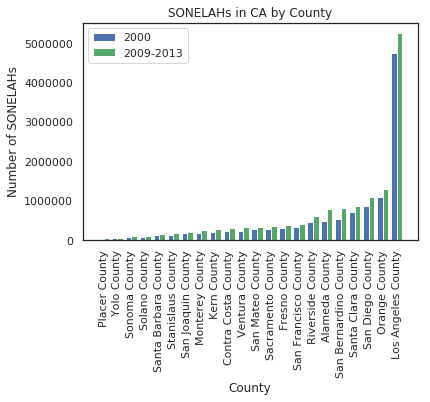

In [28]:
plotCounty("CA")

Clearly, Los Angeles has the largest number of SONELAHs by far. However, Los Angeles is a substantially large city. We suspect that the large number of SONELAHs in Los Angeles is due to the large population of Los Angeles in general. To test this, we will plot the percentages of SONELAHs per county.

/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:21: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:22: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
/home/alli/.local/lib/python3.5/site-packages/ipykernel_launcher.py:23: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


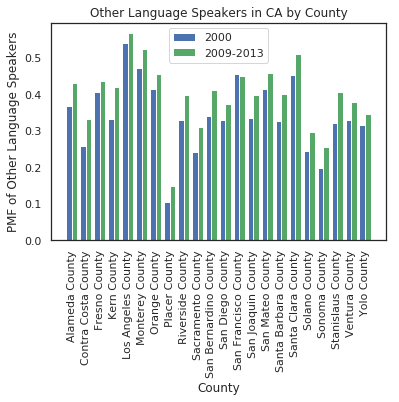

In [29]:
plotCountyPMF("CA")

Now, this graph tells us that the large difference between SONELAHs in Los Angeles and the rest of California is due to Los Angeles population. In terms of percentages of SONELAHs, California is more evenly distributed. Therefore, while you are more likely to encounter a SONELAH in Los Angeles, you are also more likely to encounter an EOS. 
</p>
This graph also shows us that while the difference in percentage of SONELAHs is not as drastic, there is not an equal distribution. Los Angeles has the most SONELAHs, at more than 50 % of the population, while Placer County has only about 10 % of its population consist of SONELAHs. 

Who are these SONELAHs, though? Because California was once part of Mexico and has Latin heritage, we suspect that a large percentage of SONELAHs in California are Spanish speakers. We also suspect that a substantial percentage of SONELAHs in California speak an Asian language, because of the west coast's proximity to Asia as well as California's history of immigration from Asia.
</p>
We are going to put that suspicion to the test by graphing different language speaking SONELAHs per county in California. We chose four language groups :'Spanish and Creole', 'German, Italian and Scandinavian', 'Asian and Pacific Island Languages' and 'Native North American Languages'. 

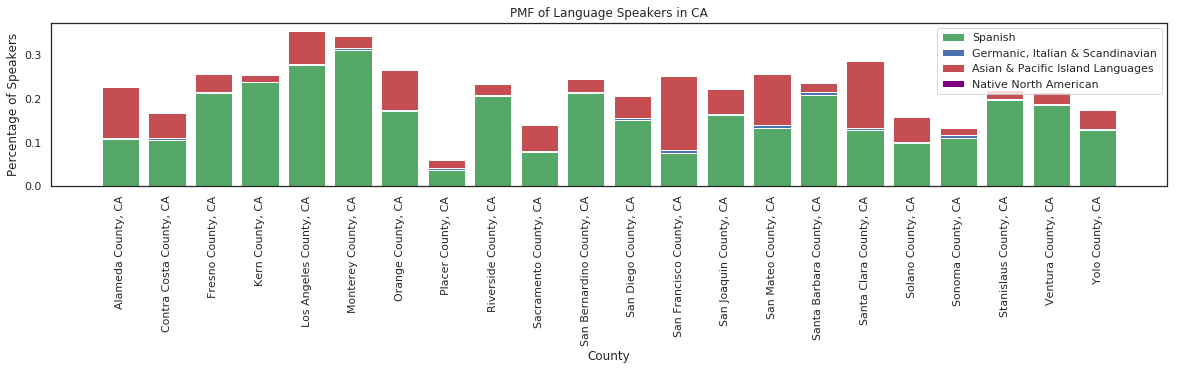

In [32]:
plotLanguagesinCounties("CA")

This graph shows what we were expecting: there is a large portion of SONELAHs in California who are Spanish speakers. There are also a significant amount of Asian and Pacific Island language speakers. 
</p>
We were surprised that in San Francisco county and in Santa Clara county, the majority of SONELAHs speak an Asian or Pacific Island language. 
</p> We also noticed that in Kenn, Stanislaus and Monterey counties, the majority of the SONELAHs language groups that we plotted were Spanish speaking. 